In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time

In [2]:
bgdfraw = pd.read_csv('boardgames_ranks.csv')

In [3]:
bgdf = bgdfraw[bgdfraw['rank'] != 0]

In [4]:
properdf = bgdf[np.abs(bgdf['bayesaverage']-bgdf['average']) <.4] # value chosen arbitrarily, based on gut intution.
#used to check lowest usersrated
properdf = properdf[properdf['usersrated']>2500] #Filterout number of usersrated that I think is too low

unproperdf = bgdf[bgdf['usersrated']<150] #Get the games I want inference on, but 15000 games is too much for inference. Maybe random sample?
unproperdf=unproperdf.sample(500)

In [5]:
unproperdf

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
14562,275087,Auf der Walz,2019,14563,5.53297,6.41806,72,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24735,220741,Yummy Yummy Pancake,2017,24736,5.48779,5.38184,129,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16994,144993,Clusterfight!,2014,16995,5.52187,6.98953,43,0,NaN,NaN,NaN,NaN,666.0,NaN,NaN,NaN
22151,368898,Rhett & Link's We're Still Good Game,2022,22152,5.50238,5.84000,35,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8378,294113,Imperial Tide: The Great War 1914-1918,2022,8379,5.60447,7.91667,105,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16878,382801,Grass is Greener,2023,16879,5.52244,7.40429,70,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25542,146596,Logo Party,2013,25543,5.47962,5.17323,130,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17208,123689,"Fornovo 1495: Dawn of the Italian Wars, 1495-1525",2016,17209,5.52102,6.98158,38,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2962.0
12288,1066,Zargos,1990,12289,5.54864,6.34558,147,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
gameIds= properdf['id']

In [6]:
gameIdsUnp = unproperdf['id']

In [7]:
#API init
rootpath = 'https://boardgamegeek.com/xmlapi2/'
gamepath = 'thing/'

## This section is mostly testing

In [10]:
ids = gameIds[760:].to_list()
ids  = ','.join(map(str, ids)) 

In [11]:
gameparameters={'id':ids,
                'stats': 1}
r=requests.get(rootpath+gamepath, params= gameparameters)

In [12]:
soup = BeautifulSoup(r.text, features='xml')

In [13]:
soup.find_all('minplayers')[0]['value']

'2'

# Create funcs used for my search

In [8]:
def get_descs(soup):
    descs = soup.find_all('description')
    descs = [item.get_text() for item in descs]
    return descs

def get_minplayer(soup):
    minplayers = soup.find_all('minplayers')
    minplayers = [item['value'] for item in minplayers]
    return minplayers
    
def get_maxplayer(soup):
    maxplayers = soup.find_all('maxplayers')
    maxplayers = [item['value'] for item in maxplayers]
    return maxplayers
##Reusing som code here, I don't want to change the names
def get_minplaytime(soup):
    minplayers = soup.find_all('minplaytime')
    minplayers = [item['value'] for item in minplayers]
    return minplayers
    
def get_maxplaytime(soup):
    maxplayers = soup.find_all('maxplaytime')
    maxplayers = [item['value'] for item in maxplayers]
    return maxplayers

def get_avgplaytime(soup):
    maxplayers = soup.find_all('playingtime')
    maxplayers = [item['value'] for item in maxplayers]
    return maxplayers

def get_cats(soup):
    items = soup.find_all('item')
    cats = []
    for item in items:
        itemtype = item.find_all('link', {'type':'boardgamecategory'})
        itemtype = [cat['value'] for cat in itemtype]
        cats += [itemtype]

    return cats

def get_mechs(soup):
    items = soup.find_all('item')
    mechs = []
    for item in items:
        itemtype = item.find_all('link', {'type':'boardgamemechanic'})
        itemtype = [mech['value'] for mech in itemtype]
        mechs += [itemtype]

    return mechs

def get_minage(soup):
    minages = soup.find_all('minage')
    minages = [item['value'] for item in minages]
    return minages

def get_complexities(soup):
    weights = soup.find_all('averageweight')
    weights = [item['value'] for item in weights]
    return weights


In [190]:
get_avgplaytime(soup)

[]

In [189]:
soup.find_all('averageweight')

[<averageweight value="1.1624"/>,
 <averageweight value="1.113"/>,
 <averageweight value="1.1715"/>,
 <averageweight value="1.6212"/>]

In [15]:
import numpy as np

In [16]:
#This one doesn't work
def get_bestplayer(soup):
    playerpolls = soup.find_all('poll', {'name':'suggested_numplayers'})
    bestplayers = []
    for poll in playerpolls:
        results = poll.find_all('results')
        counts=[]
        votes = []
        for result in results:
            counts += [result['numplayers']]
            votes += [result.find_all('result', {'value':'Best'})[0]['numvotes']]
        index_max = np.argmax(votes)
        bestplayers +=[counts[index_max]]
    
    return bestplayers

        

In [180]:
get_complexities(soup)

[]

In [152]:
np.argmax([0,1,4,3])

2

In [138]:
soup.find_all('poll', {'name':'suggested_numplayers'})[0].find_all('results')[0]['numplayers']

'1'

In [140]:
soup.find_all('poll', {'name':'suggested_numplayers'})[0].find_all('results')[0].find_all('result', {'value':'Best'})[0]['numvotes']

'0'

### Big ol search for all I need, hopfully no errors

In [17]:
descs = []
minplayers = []
maxplayers = []
avgplaytime =[]
minplaytime = []
maxplaytime = []
cats = []
mechs = []
minage = []
complexities = []
for i in range(0,len(gameIdsUnp),20):#Make jumps in index 20 at a time
    if i == 760:
        ids = gameIdsUnp[i:].to_list()
        ids  = ','.join(map(str, ids))
    else:
        ids = gameIdsUnp[i:i+20].to_list() # Get ids 20 at a time
        ids  = ','.join(map(str, ids))
    
    gameparameters={'id':ids,
                    'stats':1}
    r=requests.get(rootpath+gamepath, params= gameparameters)
    if r.status_code!=200:  # make sure I'm not banned or somthing
        time.sleep(30)
        r=requests.get(rootpath+gamepath, params= gameparameters)
        if r.status_code!=200:
            print(f"Error Code:{r.status_code}, iteration:{i}")
            break
    
    soup = BeautifulSoup(r.text, features='xml') 
    descs += get_descs(soup)
    minplayers += get_minplayer(soup)
    maxplayers += get_maxplayer(soup)
    avgplaytime += get_avgplaytime(soup)
    minplaytime += get_minplaytime(soup)
    maxplaytime += get_maxplaytime(soup)
    cats += get_cats(soup)
    mechs += get_mechs(soup)
    minage += get_minage(soup)
    complexities += get_complexities(soup)

    time.sleep(5)


AVG playtime and complexities broken

In [197]:
len(avgplaytime)

764

In [18]:
testingdata = unproperdf[['id','name','yearpublished', 'bayesaverage']]

In [155]:
trainingdata = properdf[['id','name','yearpublished', 'bayesaverage']]

In [19]:
testingdata['avgplaytime']=avgplaytime
testingdata['complexity']=complexities

C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\548426073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingdata['avgplaytime']=avgplaytime
C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\548426073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingdata['complexity']=complexities


In [198]:
trainingdata['avgplaytime']=avgplaytime
trainingdata['complexity']=complexities

C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\3746555790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingdata['avgplaytime']=avgplaytime
C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\3746555790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingdata['complexity']=complexities


In [20]:
testingdata['descriptions']=descs
testingdata['minplayers']=minplayers
testingdata['maxplayers']=maxplayers
testingdata['minplaytime']=minplaytime
testingdata['maxplaytime']=maxplaytime
testingdata['categories']=cats
testingdata['mechanics']=mechs
testingdata['minage']=minage

C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\378545387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingdata['descriptions']=descs
C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\378545387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingdata['minplayers']=minplayers
C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\378545387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [177]:
trainingdata['descriptions']=descs
trainingdata['minplayers']=minplayers
trainingdata['maxplayers']=maxplayers
trainingdata['minplaytime']=minplaytime
trainingdata['maxplaytime']=maxplaytime
trainingdata['categories']=cats
trainingdata['mechanics']=mechs
trainingdata['minage']=minage


C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\1656319451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingdata['descriptions']=descs
C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\1656319451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingdata['minplayers']=minplayers
C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\1656319451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [21]:
testingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']] = testingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']].apply(pd.to_numeric)

C:\Users\caleb\AppData\Local\Temp\ipykernel_19800\3784819446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']] = testingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']].apply(pd.to_numeric)


In [221]:
trainingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']] = trainingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']].apply(pd.to_numeric)

C:\Users\caleb\AppData\Local\Temp\ipykernel_6516\1658402947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']] = trainingdata[['minplayers','maxplayers','minplaytime','maxplaytime','minage','avgplaytime','complexity']].apply(pd.to_numeric)


In [22]:
testingdata

,id,name,yearpublished,bayesaverage,avgplaytime,complexity,descriptions,minplayers,maxplayers,minplaytime,maxplaytime,categories,mechanics,minage
14562,275087,Auf der Walz,2019,5.53297,150,2.6667,Auf der Walz is a game that has the &quot;jour...,2,4,90,150,"[Exploration, Travel]","[Action Points, Hand Management, Network and R...",10
24735,220741,Yummy Yummy Pancake,2017,5.48779,15,1.0000,"In Yummy Yummy Pancake, you're trying to ident...",2,4,15,15,[Children's Game],"[Deduction, Memory]",6
16994,144993,Clusterfight!,2014,5.52187,45,1.0000,Clusterfight is a party game of hypothetical b...,3,12,45,45,"[Card Game, Fighting, Humor, Party Game]","[Betting and Bluffing, Storytelling, Take That]",8
22151,368898,Rhett & Link's We're Still Good Game,2022,5.50238,30,1.5000,FROM THE GOOD MYTHICAL MORNING DUO: Dive into ...,4,12,30,30,[Party Game],"[Questions and Answers, Storytelling]",16
8378,294113,Imperial Tide: The Great War 1914-1918,2022,5.60447,240,2.3333,Imperial Tide is a 2-player strategic level wa...,1,2,180,240,"[Wargame, World War I]","[Area Movement, Card Play Conflict Resolution,...",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16878,382801,Grass is Greener,2023,5.52244,45,1.6000,Strategize and scheme against your neighbors i...,2,6,20,45,[Card Game],[],13
25542,146596,Logo Party,2013,5.47962,60,1.2000,Official Game Description:&#10;&#10;It's not w...,4,0,30,60,[Party Game],"[Acting, Paper-and-Pencil, Team-Based Game]",8
17208,123689,"Fornovo 1495: Dawn of the Italian Wars, 1495-1525",2016,5.52102,180,3.2500,Order of Arms is a simulation game of battles ...,1,2,180,180,"[Renaissance, Wargame]","[Area Movement, Dice Rolling, Movement Points,...",12
12288,1066,Zargos,1990,5.54864,120,2.6923,Principle of the game:&#10;The players' goal i...,2,6,120,120,"[Fantasy, Medieval, Territory Building]","[Area Movement, Dice Rolling, Variable Player ...",12


In [23]:
##Just to save my work so far
testingdata.to_csv('testingdata.csv')

In [223]:
##Just to save my work so far
#trainingdata.to_csv('trainingdata.csv')

REMEMBER TO FEED THROUGH TESTING DATA (when needed)

In [204]:
def Numeric_EDA(data):
    length = len(data)
    mean = np.mean(data)
    sd = np.std(data)
    summary = np.percentile(data, [0, 25, 50, 75, 100])
    return length, mean, sd, summary

In [224]:
np.mean(trainingdata['minplayers'])

1.9594240837696335

In [230]:
Numeric_EDA(trainingdata['complexity'])

(764,
 2.125364659685864,
 0.7940418077090179,
 array([1.0158 , 1.47715, 2.00455, 2.6145 , 4.4365 ]))

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

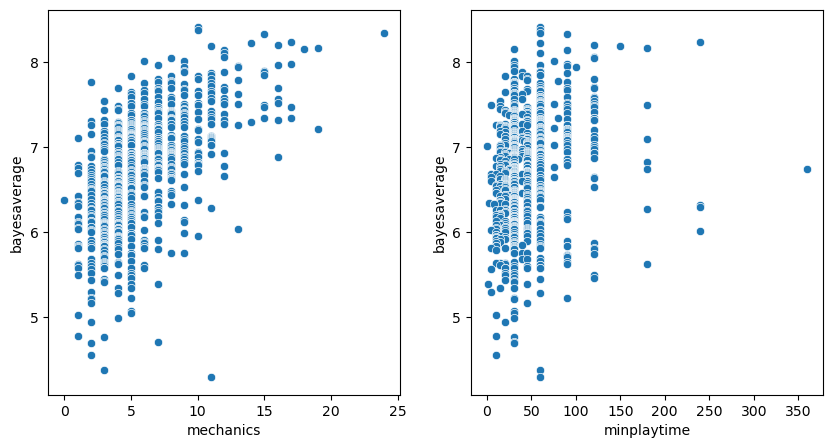

In [240]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.scatterplot(data=trainingdata, x=trainingdata['mechanics'].apply(len), y='bayesaverage')
plt.subplot(1,2,2)

sns.scatterplot(data=trainingdata, x='minplaytime', y='bayesaverage')
plt.show()